In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.decomposition import PCA
from PIL import Image
from sklearn.model_selection import train_test_split
from math import floor
from sklearn.preprocessing import StandardScaler

In [ ]:
!unzip -uq "/content/drive/My Drive/DL_HW1/UTKFace.zip" -d "/content" #unzipping zipped file of pictures on \content

In [ ]:
#This line below, return names of items in a directory as a list
images_names=listdir('/content/UTKFace')

#labels

name_sections=[images_names[i].split('_') for i in range(np.shape(images_names)[0])]
Gender=[int(name_sections[i][1]) for i in range(np.shape(images_names)[0])]

Man=[]
Woman=[]

for i in range(len(Gender)):
  if Gender[i]==0:
    Man.append(i)
  else:
    Woman.append(i)

print('Man len is',len(Man))
print('Woman len is',len(Woman))

def Gender_Label(gender,n):
  lst=[]
  if gender=='Man':
    for i in range(n):
      lst.append(0)
  else:
    for i in range(n):
      lst.append(1)
  return lst


#picking 5000 pictures, 2500 men and 2500 women
n_sam_man=2500
n_sam_woman=2500

Man_sam=random.sample(Man, n_sam_man)
Man_label=Gender_Label('Man',n_sam_man)

Woman_sam=random.sample(Woman, n_sam_woman)
Woman_label=Gender_Label('Woman',n_sam_woman)


Man_sam.extend(Woman_sam)
Gender_sam=Man_sam
Man_label.extend(Woman_label)
Gender_label=Man_label

zipped=list(zip(Gender_sam,Gender_label))

random.shuffle(zipped)
random.shuffle(zipped)
random.shuffle(zipped)

unzipped=list(zip(*zipped))

Gender_sam=list(unzipped[0])
Gender_label=list(unzipped[1])


Man len is 12392
Woman len is 11316


In [ ]:
#loading data

loaded_images = []
for i in Gender_sam:
  img=image.imread('/content/UTKFace/' + images_names[i])
  loaded_images.append(img)

loaded_images=np.asarray(loaded_images,dtype='float16')

loaded_images=loaded_images.reshape(np.shape(loaded_images)[0],3*200*200)

Gender_label=np.asarray(Gender_label)

print(np.shape(loaded_images),loaded_images.dtype)

(5000, 120000) float16


In [ ]:
#Test,Train,validation data splitting +standardization+PCA
#Standardization is applied before and after applying PCA
X, X_test_, Y, Y_test = train_test_split(loaded_images, Gender_label, test_size=0.2, random_state=1)

loaded_images=[]

scaler=StandardScaler().fit(X)
X=scaler.transform(X)
X_test_=scaler.transform(X_test_)

pca=PCA(n_components=128)

#because RAM would be filled because it considered PCA output as 'float64', there was a need to trick python!
XX=np.zeros((np.shape(X)[0],128),dtype='float16')
XX=pca.fit(X).transform(X)
X=[]

X_test=np.zeros((np.shape(X_test_)[0],128),dtype='float16')
X_test=pca.transform(X_test_)
X_test_=[]

X_train, X_val, Y_train, Y_val = train_test_split(XX, Y, test_size=0.1, random_state=1)

XX=[]
Y=[]

Y_train=Y_train.reshape(Y_train.shape[0],1)
Y_test=Y_test.reshape(Y_test.shape[0],1)
Y_val=Y_val.reshape(Y_val.shape[0],1)

scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)


print(X_train.shape, X_test.shape, X_val.shape , Y_train.shape, Y_test.shape, Y_val.shape)

(3600, 128) (1000, 128) (400, 128) (3600, 1) (1000, 1) (400, 1)


In [ ]:
#Only for creating mini batches, I used a pre-written function code from the internet and adjusted it
#https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/

def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 

  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
 
    return mini_batches 

In [ ]:
#Initialization for weights
#it either uses zeros initialization or He initialization
#details about He method is writen in the report
def initialization(neurons_lst):
  W={}
  b={}
  last_l=len(neurons_lst)-1
  for i in range(1,last_l):
    W[i]=np.random.randn(neurons_lst[i],neurons_lst[i-1])*np.sqrt(2/neurons_lst[i-1])
    #W[i]=np.random.randn(neurons_lst[i],neurons_lst[i-1])
    b[i]=np.random.randn(neurons_lst[i],1)*np.sqrt(2/neurons_lst[i-1])
    #b[i]=np.random.randn(neurons_lst[i],1)
  W[last_l]=np.random.randn(neurons_lst[last_l],neurons_lst[last_l-1])*np.sqrt(1/neurons_lst[last_l-1])
  b[last_l]=np.random.randn(neurons_lst[last_l],1)*np.sqrt(1/neurons_lst[last_l-1])
  return W,b

In [ ]:
#Activation functions and the derivatives
def Leaky_Relu(Z):
  return np.maximum(0.05*Z,Z)

def d_Leaky_Relu(Z):
  d_g_Z=0.05*np.ones(Z.shape)
  d_g_Z[Z>=0]=1
  return d_g_Z

def Sigmoid(Z):
  return 1/(1+np.exp(-Z))

def d_Sigmoid(A):
  return A*(1-A)

In [ ]:
#forward propagation
def forward(X,W,b,neurons_lst):
  Z={}
  A={}
  A[0]=np.copy(X.T)
  output_l=len(neurons_lst)-1
  for i in range(1,output_l):
    Z[i]=W[i].dot(A[i-1])+b[i]
    A[i]=Leaky_Relu(Z[i])

  Z[output_l]=W[output_l].dot(A[output_l-1])+b[output_l]
  A[output_l]=Sigmoid(Z[output_l])
  Y=np.copy(A[output_l])
  return Z,A,Y

In [ ]:
#backward propagation
def backward(X,Z,A,W,Y,target,neurons_lst):

  layer_out=len(neurons_lst)-1

  m=(int(Y.size))/5

  dZ={}
  dW={}
  db={}

  dZ[layer_out]=Y-target
  dW[layer_out]=(1/m)*dZ[layer_out].dot(A[layer_out-1].T)
  db[layer_out]=(1/m)*np.sum(dZ[layer_out],axis=1,keepdims=True)


  for i in reversed(range(1,layer_out)):
    dZ[i]=W[i+1].T.dot(dZ[i+1])*d_Leaky_Relu(Z[i])
    dW[i]=(1/m)*dZ[i].dot(A[i-1].T)
    db[i]=(1/m)*np.sum(dZ[i],axis=1,keepdims=True)

  return dW,db

In [ ]:
#leraning rate
#it either uses constant steps for decreasing lr or uses step decay
def learning_rate(alpha0,epoch,epoch_batch=10,rate=0.5,const_step=0.01,constant=False):
  if constant==False:
    lr=alpha0*(rate**floor(epoch / epoch_batch))
    return lr
  else:
    return alpha0-const_step*alpha0*floor(epoch / epoch_batch)

In [ ]:
#initializing V for momemtum in weight updating
def init_v(W,b):
  vw={}
  vb={}
  for i in range(1,len(W)+1):
    vw[i]=np.zeros(np.shape(W[i]))
    vb[i]=np.zeros(np.shape(b[i]))
  return vw,vb

In [ ]:
#updating Weights and biases
#Requlation can be applied or not
def update(W,b,dW,db,vw,vb,alpha,neurons_lst,momentum=0.9,regulation=True,Lambda=3):
  if regulation==True:
    Lambda=Lambda
  else:
    Lambda=0
  for i in range(1,len(neurons_lst)):
    vw[i]=momentum*vw[i]+alpha*dW[i]
    W[i]=W[i]-vw[i]-alpha*Lambda*W[i]
    vb[i]=momentum*vb[i]+alpha*db[i]
    b[i]=b[i]-vb[i]
  return W,b,vw,vb

In [ ]:
#Cost function
def cost(Y,target):
  m=int(Y.size)
  l=-target*np.log(Y)-(1-target)*np.log(1-Y)
  return np.sum(l)/m

In [ ]:
#Accuracy: how good can this MLP predict?
def acc_prediction(Y,target):
  pre=Y>0.49999 #Output 0.5 and above will be considered as label 1
  tar=target==1
  acc=np.sum(pre==tar)/((tar.size))
  return acc

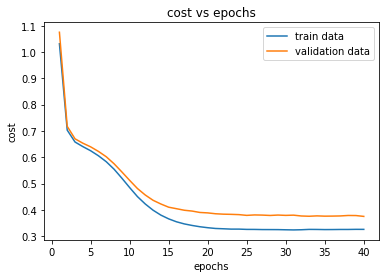

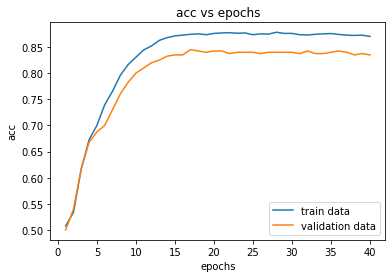

In [ ]:
neurons_lst=[128,50,30,1]
batch_size=128
epochs=40

(W,b)=initialization(neurons_lst)

train_cost=[]
val_cost=[]
train_acc=[]
val_acc=[]

(vw,vb)=init_v(W,b)

for i in range(epochs):
  cost_valu=0
  mini_batches=create_mini_batches(X_train,Y_train,batch_size)
  alpha=learning_rate(0.001,i+1,epoch_batch=10,const_step=0.1,constant=True) #constant step for decreasing lr : 0.001*0.1
  


  (Z,A,Y)=forward(X_train,W,b,neurons_lst)
  train_cost.append(cost(Y,Y_train.T))
  train_acc.append(acc_prediction(Y,Y_train.T))

  (Z_val,A_val,Y_v)=forward(X_val,W,b,neurons_lst)
  val_cost.append(cost(Y_v,Y_val.T))
  val_acc.append(acc_prediction(Y_v,Y_val.T))



  for mini_batch in mini_batches:
    data_train=np.copy(mini_batch[0])
    train_label=np.copy(mini_batch[1])
    M=np.shape(train_label)[0]
    train_label=train_label.reshape(1,M)

    (Z,A,Y)=forward(data_train,W,b,neurons_lst)
    (dW,db)=backward(data_train,Z,A,W,Y,train_label,neurons_lst)

    (W,b,vw,vb)=update(W,b,dW,db,vw,vb,alpha,neurons_lst,regulation=True)


plt.figure()
nn1=list(range(1,len(train_cost)+1))
plt.plot(nn1,train_cost)
nn2=list(range(1,len(val_cost)+1))
plt.plot(nn2,val_cost)
plt.title('cost vs epochs')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend(['train data','validation data'])

plt.figure()
nn3=list(range(1,len(train_acc)+1))
plt.plot(nn3,train_acc)
nn4=list(range(1,len(val_acc)+1))
plt.plot(nn4,val_acc)
plt.title('acc vs epochs')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train data','validation data'])

In [ ]:
#Test accuracy
_,_,output_test=forward(X_test,W,b,neurons_lst)

print(acc_prediction(output_test,Y_test.T))

0.844
